In [1]:
# LOAD PACKAGES
from scipy.spatial.transform import Rotation as R
import numpy as np
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
import math

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# PREPARE DATA

# Load data
df = pd.read_table('/Users/rhemitoth/Documents/PhD/Cembra/Dead_Reckoning/Data/Gundog_Tutorial/L1_continuous_export_split#3.txt.txt')
gps = pd.read_csv('/Users/rhemitoth/Documents/PhD/Cembra/Dead_Reckoning/Data/Gundog_Tutorial/L1.GPS.UTM.csv')

#list(df.columns)

# Convert timestamp from string to datetime

df['datetime_txt'] = df['Date'] + " " + df['Time hh:mm:ss.ddd']
df['datetime'] = pd.to_datetime(df['datetime_txt'], format = '%d/%m/%Y %H:%M:%S.%f')

gps['datetime_txt'] = gps['Date'] + " " + gps['Time']
gps['datetime'] = pd.to_datetime(gps['datetime_txt'], format = '%d/%m/%Y %H:%M:%S')

# Select Columns
df = df[['Acc_x',
        'Acc_y',
        'Acc_z',
        'Mag_x',
        'Mag_y',
        'Mag_z',
        'datetime']]

# Compute 1 second averages
df.set_index('datetime', inplace=True, drop = False)
df = df.resample('1s').mean()
df = df.reset_index(drop=True)
df['datetime'] = df['datetime'].dt.floor('s')

# Calculate elapsed time
df['elapsed_time'] = df['datetime'].diff().apply(lambda x: x.total_seconds())

# Merge GPS and activity data
df = pd.merge(df, gps, on='datetime', how='left')


# Apply a flag for 1st GPS fix of every hour
def mark_ground_truth(row):
    seconds = row['datetime'].second
    if seconds == 0:
        return 1
    else:
        return 0
        
df['ground_truth'] = df.apply(mark_ground_truth,axis=1)

In [3]:
# Set groups for applying heading and speed corrections

df['groupID'] = 0
group = 0

for i in range(len(df)-1 ):
    # check if row contains a ground truth point
    gtp = df.loc[i,'ground_truth']
    # If row contains a GTP start a new group on the next row
    if gtp == 1:
        group += 1
    # Assign group of next row
    df.loc[i+1,'groupID'] = group

df.head(65)

,Acc_x,Acc_y,Acc_z,Mag_x,Mag_y,Mag_z,datetime,elapsed_time,Date,Time,location.lat,location.long,Height.above.msl,UTM_E,UTM_N,datetime_txt,ground_truth,groupID
0,-0.086304,-0.208716,-0.997119,-0.037402,0.071558,-0.270996,2019-02-25 22:24:00,NaN,25/02/2019,22:24:00,-26.167846,20.798018,914.0,479814.898495,7.105712e+06,25/02/2019 22:24:00,1,0
1,-0.038428,-0.173926,-1.043873,-0.006323,0.064746,-0.272217,2019-02-25 22:24:01,1.0,25/02/2019,22:24:01,-26.167847,20.798009,914.0,479813.999248,7.105712e+06,25/02/2019 22:24:01,0,1
2,0.041919,-0.208667,-1.012673,0.033252,0.066309,-0.263891,2019-02-25 22:24:02,1.0,25/02/2019,22:24:02,-26.167849,20.798000,914.0,479813.100174,7.105712e+06,25/02/2019 22:24:02,0,1
3,0.148633,-0.193091,-1.013867,0.047485,0.065674,-0.259741,2019-02-25 22:24:03,1.0,25/02/2019,22:24:03,-26.167850,20.797992,914.0,479812.300863,7.105712e+06,25/02/2019 22:24:03,0,1
4,0.161817,-0.191895,-1.016260,0.047217,0.066699,-0.260522,2019-02-25 22:24:04,1.0,25/02/2019,22:24:04,-26.167851,20.797985,914.0,479811.601487,7.105712e+06,25/02/2019 22:24:04,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,-0.076733,-0.224268,-0.939478,0.020654,0.032324,-0.271533,2019-02-25 22:25:00,1.0,25/02/2019,22:25:00,-26.167711,20.797648,910.0,479777.899109,7.105727e+06,25/02/2019 22:25:00,1,1
61,-0.128369,-0.217139,-1.066674,0.023169,0.028760,-0.272851,2019-02-25 22:25:01,1.0,25/02/2019,22:25:01,-26.167708,20.797638,908.0,479776.899236,7.105728e+06,25/02/2019 22:25:01,0,2
62,-0.111499,-0.205078,-0.945460,0.016553,0.039453,-0.272388,2019-02-25 22:25:02,1.0,25/02/2019,22:25:02,-26.167703,20.797628,908.0,479775.899018,7.105728e+06,25/02/2019 22:25:02,0,2
63,-0.197852,-0.238696,-1.028247,-0.001001,0.032178,-0.274927,2019-02-25 22:25:03,1.0,25/02/2019,22:25:03,-26.167699,20.797619,908.0,479774.998909,7.105729e+06,25/02/2019 22:25:03,0,2


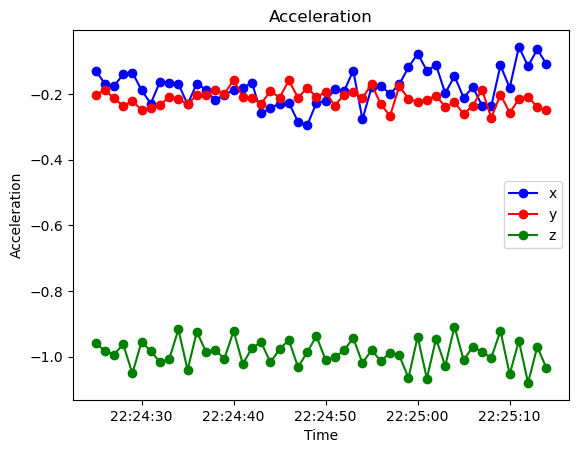

In [4]:
# PLOT ACCELERATION OVER TIME
Acc_x = df['Acc_x'].iloc[25:75]
Acc_y = df['Acc_y'].iloc[25:75]
Acc_z = df['Acc_z'].iloc[25:75]
dt = df['datetime'].iloc[25:75]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(dt, Acc_x, marker='o', linestyle='-', color='b', label='x')
ax.plot(dt, Acc_y, marker='o', linestyle='-', color='r', label='y')
ax.plot(dt, Acc_z, marker='o', linestyle='-', color='g', label='z')

# Setting labels
ax.set_xlabel('Time')
ax.set_ylabel('Acceleration')

# Adding a title and legend
ax.set_title('Acceleration')
ax.legend()

# Show plot
plt.show()

## STEP 1: COMPUTE ACCELERATION COMPONENTS
Static acceleration is the acceleration component due to the pull of gravity. Following Shepard et al. 2008, static acceleration can be approximated using a moving average. According to Shepard et al. 2008, the length of the running mean should correspond to the point (or follow the point) where calculated overall dynamic body acceleration (ODBA) stabizes.


/var/folders/bp/jpzs1ydd4dj8jj8kv5fx8wq80000gn/T/ipykernel_5486/1842209085.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['Gx'] = res['Acc_x'].rolling(window=win).mean()
/var/folders/bp/jpzs1ydd4dj8jj8kv5fx8wq80000gn/T/ipykernel_5486/1842209085.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['Gy'] = res['Acc_y'].rolling(window=win).mean()
/var/folders/bp/jpzs1ydd4dj8jj8kv5fx8wq80000gn/T/ipykernel_5486/1842209085.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

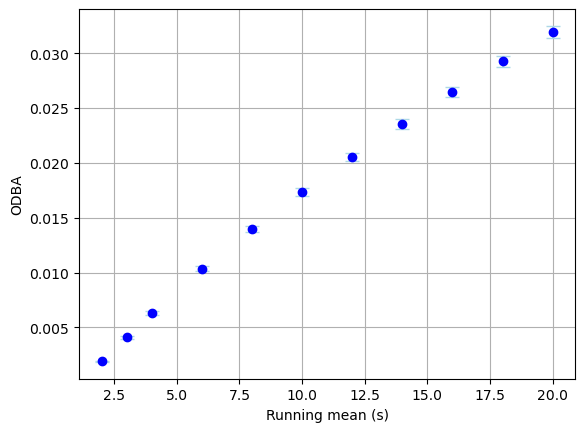

In [5]:
# WINDOW LENGTH SELECTION

# Possible window lengths
windows = [2,3,4,6,8,10,12,14,16,18,20]

# Set up dataframe to store results
acc_data = df[['Acc_x','Acc_y','Acc_z']]
window_results = pd.DataFrame(columns = ['Acc_x','Acc_y','Acc_z','Gx','Gy','Gz','DAx','DAy','DAz','ODBA','WindowLength'])

# Compute static acceleration using possible window lengths
for win in windows:
    # Get raw acceleration and set up results table
    res = acc_data
    # Compute static acceleration using rolling mean
    res['Gx'] = res['Acc_x'].rolling(window=win).mean()
    res['Gy'] = res['Acc_y'].rolling(window=win).mean()
    res['Gz'] = res['Acc_z'].rolling(window=win).mean()
    # Compute dynamic acceleration
    res['DAx'] = res['Acc_x'] - res['Gx']
    res['DAy'] = res['Acc_y'] - res['Gy']
    res['DAz'] = res['Acc_z'] - res['Gz']
    # Compute ODBA
    res['ODBA'] = res['DAx'] ** 2 + res['DAy'] ** 2 + res['DAz'] ** 2
    # Store Results
    res['WindowLength'] = [win]*len(res)
    res.head(10)
    window_results = pd.concat([window_results, res], ignore_index=True)

# Plot results
grouped = window_results.groupby('WindowLength')['ODBA']
means = grouped.mean()
std_errors = grouped.sem()
plt.errorbar(means.index, means, yerr=std_errors, fmt='o', color='blue', ecolor='lightblue', capsize=5)
plt.xlabel('Running mean (s)')
plt.ylabel('ODBA')
plt.grid(True)
plt.show()


In [6]:
# CALCULATE STATIC ACCELERATION
w = 10
df['Gx'] = df['Acc_x'].rolling(window=w).mean()
df['Gy'] = df['Acc_y'].rolling(window=w).mean()
df['Gz'] = df['Acc_z'].rolling(window=w).mean()

# Remove rows with NaN static accleration
df = df.iloc[w-1:].reset_index(drop=True)


In [7]:
# CALCULATE DYNAMIC ACCELERATION
df['DAx'] = df['Acc_x']-df['Gx']
df['DAy'] = df['Acc_y']-df['Gy']
df['DAz'] = df['Acc_z']-df['Gz']

In [8]:
# CALCULATE VeDBA
df['VeDBA']= (df['DAx']**2 + df['DAy']**2 + df['DAz']**2)**0.5

## STEP 2: COMPUTE PITCH AND ROLL
- Pitch = rotation about the lateral axis
- Roll = rotation about the anterior-posterior axis
- Yaw (heading) = rotation about the dorso-ventral axis.

In [9]:
# COMPUTE PITCH

# Function to compute roll
def calculate_pitch(row):
    gx = row['Gx']
    gy = row['Gy']
    gz = row['Gz']
    pitch = math.atan2(gx,math.sqrt(gy**2 + gz**2))
    return(pitch)

# Compute roll
df['pitch']=df.apply(calculate_pitch,axis=1)


In [10]:
# COMPUTE ROLL

# Function to compute roll
def calculate_roll(row):
    gx = row['Gx']
    gy = row['Gy']
    gz = row['Gz']
    roll = math.atan2(gx,math.sqrt(gy**2 + gz**2))
    return(roll)

# Compute roll
df['roll']=df.apply(calculate_roll,axis=1)

## STEP 3: CORRECT MAGNETOMETER DATA


In [11]:
# Filter for calibration events
# df_cal = df[df['Marked.event']==2]

# Calculate offsetts
# Ox = (df['Mag_x'].max() - df['Mag_x'].min())/2
# Oy = (df['Mag_y'].max() - df['Mag_y'].min())/2
# Oz = (df['Mag_z'].max() - df['Mag_z'].min())/2

# Correct Magnetometer Output
# df['Mx'] = df['Mag_x'] - Ox
# df['My'] = df['Mag_y'] - Oy
# df['Mz'] = df['Mag_z'] - Oz

## STEP 4: NORMALIZE COMPASS DATA

In [12]:
# Function to compute normalization factor
def calc_normalization_factor(row):
    Mx = row['Mag_x']
    My = row['Mag_y']
    Mz = row['Mag_z']
    fm = math.sqrt(Mx**2 + My**2 + Mz**2)
    return fm

# Compute normalization factor
df['fm'] = df.apply(calc_normalization_factor,axis=1)

# Normalize compass data
df['NMx'] = df['Mag_x']/df['fm']
df['NMy'] = df['Mag_y']/df['fm']
df['NMz'] = df['Mag_z']/df['fm']

## STEP 5: ROTATE AXES ACCORDING TO PITCH AND ROLL 

In [13]:
# Function to generate pitch rotation matrix
def get_rx(pitch):
    Rx = np.array([[1,0,0],
          [0,math.cos(pitch),math.sin(pitch)],
          [0,-math.sin(pitch),math.cos(pitch)]])
    return Rx

# Function to generate roll rotation matrix
def get_ry(roll):
    Ry = np.array([[math.cos(roll),0,-math.sin(roll)],
         [0,1,0],
         [math.sin(roll),0,math.cos(roll)]])
    return Ry


# Function to generate yaw rotation matrix
def get_rz(yaw):
    Rz = np.array([[math.cos(yaw), math.sin(yaw),0],
                 [-math.sin(yaw), math.cos(yaw), 0],
                 [0,0,1]])
    return Rz

# Function to rotate axes by pitch and roll
def rotate_axes(row):
    NMx = row['NMx']
    NMy = row['NMy']
    NMz = row['NMz']
    NM = np.array([NMx,NMy,NMz])
    
    pitch = row['pitch']
    Rx = get_rx(pitch = pitch)
    
    roll = row['roll']
    Ry = get_ry(roll = roll)
    
    RNM = np.dot(NM,np.dot(Rx,Ry))

    row['RNMx'] = RNM[0]
    row['RNMy'] = RNM[1]
    return(row)

# Rotate axes of magnetometer output
df['RNMx'] = -999
df['RNMy'] = -999
df = df.apply(rotate_axes,axis=1)

## STEP 5: DERIVE HEADING

In [14]:
# Function to derive heading
def get_yaw(row):
    NMx = row['NMx']
    NMy = row['NMy']
    NMz = row['NMz']
    pitch = row['pitch']
    roll = row['roll']
    yaw = np.arctan2(
    NMx * np.cos(roll) - NMz * np.sin(roll),
    NMx * np.cos(pitch) + NMy * np.sin(pitch) * np.sin(roll) + NMz * np.sin(pitch) * np.cos(roll)
    )
    return yaw

# Calculate heading
df['yaw'] = df.apply(get_yaw,axis = 1)

## STEP 6: CALCULATE SPEED FROM VEDBA

In [15]:
# Initialize constants with nominal values
# These will be changed later on when aligning dead-reckoned trajectories with GPS

m = 1
c = 0.1
df['m'] = m # constant of proportionality
df['c'] = c # constant

# Calculate speed (speed = (m*VeDBA)+c
df['s'] = m*df['VeDBA'] + c

# Calculate distance (distance = speed * time)
df['d'] = df['s'] * df['elapsed_time']
df.head(10)


,Acc_x,Acc_y,Acc_z,Mag_x,Mag_y,Mag_z,datetime,elapsed_time,Date,Time,...,roll,fm,NMx,NMy,NMz,yaw,m,c,s,d
0,0.178736,-0.191895,-1.023440,0.055469,0.067676,-0.259644,2019-02-25 22:24:09,1.0,25/02/2019,22:24:09,...,0.107142,0.273992,0.202447,0.246999,-0.947632,1.241688,1,0.1,0.167368,0.167368
1,0.189478,-0.189502,-1.023487,0.057129,0.067090,-0.258252,2019-02-25 22:24:10,1.0,25/02/2019,22:24:10,...,0.133071,0.272872,0.209362,0.245866,-0.946424,1.314241,1,0.1,0.150423,0.150423
2,0.182300,-0.188306,-1.010278,0.062183,0.065405,-0.257812,2019-02-25 22:24:11,1.0,25/02/2019,22:24:11,...,0.154322,0.273152,0.227649,0.239447,-0.943844,1.339237,1,0.1,0.122824,0.122824
3,0.194287,-0.184717,-1.015016,0.077222,0.057056,-0.253369,2019-02-25 22:24:12,1.0,25/02/2019,22:24:12,...,0.168681,0.270951,0.285002,0.210575,-0.935111,1.277772,1,0.1,0.118788,0.118788
4,0.189502,-0.195484,-1.001856,0.079932,0.054590,-0.251123,2019-02-25 22:24:13,1.0,25/02/2019,22:24:13,...,0.172698,0.269132,0.296998,0.202837,-0.933086,1.269775,1,0.1,0.118747,0.118747
5,0.190699,-0.196680,-1.006617,0.081909,0.053735,-0.250024,2019-02-25 22:24:14,1.0,25/02/2019,22:24:14,...,0.175549,0.268531,0.305027,0.200109,-0.931083,1.264653,1,0.1,0.113771,0.113771
6,0.200269,-0.199072,-1.016284,0.084253,0.052563,-0.249024,2019-02-25 22:24:15,1.0,25/02/2019,22:24:15,...,0.177614,0.268094,0.314267,0.196064,-0.928868,1.256481,1,0.1,0.116719,0.116719
7,0.196680,-0.201489,-1.009032,0.085132,0.052539,-0.249072,2019-02-25 22:24:16,1.0,25/02/2019,22:24:16,...,0.180703,0.268412,0.317169,0.195741,-0.927949,1.259084,1,0.1,0.113428,0.113428
8,0.202661,-0.199072,-1.006665,0.083789,0.052344,-0.248804,2019-02-25 22:24:17,1.0,25/02/2019,22:24:17,...,0.183324,0.267701,0.312995,0.195531,-0.929409,1.270705,1,0.1,0.114498,0.114498
9,0.205053,-0.196680,-1.012647,0.082886,0.054736,-0.251929,2019-02-25 22:24:18,1.0,25/02/2019,22:24:18,...,0.185023,0.270803,0.306074,0.202126,-0.930303,1.283493,1,0.1,0.112322,0.112322


## STEP 7: PERFORM DEAD RECKONING CALCULATION

In [16]:
# Set start and end for calculation
start = 51
end = 652
df = df.iloc[start:end]

# Create rowID column
df['rowID'] = range(0,len(df)) 
df['rowID'] += start


In [17]:
# Initialize the transformation matrix
transformation_matrix = np.eye(4)
transformation_matrix

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [18]:
# Initialize position
position = np.array([[0],[0],[0]])
utm_x = df.loc[start,'UTM_E']
utm_y = df.loc[start,'UTM_N']

# Initialize columns for dead-reckoned coordinates
df['DR_x'] = -999.0
df.loc[start,'DR_x'] = 0
df['DR_y'] = -999.0
df.loc[start,'DR_y'] = 0
df['DR_z'] = -999.0
df.loc[start,'DR_z'] = -999.0
df['DR_utm_x'] = -999.0
df.loc[start,'DR_utm_x'] = df.loc[start,'UTM_E']
df['DR_utm_y'] = -999.0
df['DR_utm_y'] = df.loc[start,'UTM_N']

# Initialize direciton
initial_direction = np.array([[0],[1],[0]])

In [19]:
# Perform dead reckoning

for i in range(len(df)-1 ):

    i += start
    
    global transformation_matrix
    global position
    global direction_vector
        
    # Construct the rotation matrix
    pitch = df.loc[i,'pitch']
    roll = df.loc[i,'roll']
    yaw = df.loc[i,'yaw']
    Rx = get_rx(pitch)
    Ry = get_ry(roll)
    Rz = get_rz(yaw)
    rotation_matrix = Rz @ Ry @ Rx

    # Compute the displacement vector
    direction_vector = rotation_matrix @ initial_direction
    distance = df.loc[i,'d']
    displacement_vector = direction_vector * distance
        
    #update homo_trans_step
    transformation_step = np.append(np.append(rotation_matrix, np.zeros([3,1]), axis = 1), np.array([[0,0,0,1]]), axis = 0)
    transformation_step[:3,-1] = displacement_vector.flatten()

    # Perform initial calculation of coordinates
    current_position = position
    next_position = current_position + displacement_vector
    df.loc[i+1,'DR_x'] = next_position[0]
    df.loc[i+1,'DR_utm_x'] = displacement_vector[0] + df.loc[i,'DR_utm_x']
    df.loc[i+1,'DR_y'] = next_position[1]
    df.loc[i+1,'DR_utm_y'] = displacement_vector[1] + df.loc[i,'DR_utm_y']
    df.loc[i+1,'DR_z'] = next_position[2]

    # Update position
    position = next_position


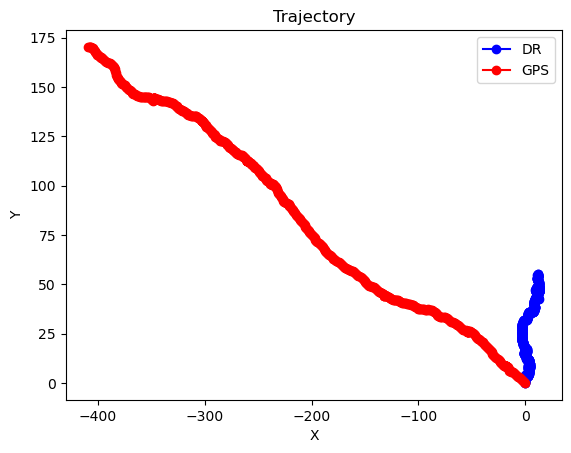

In [20]:
# Plot dead reckoned vs GPS trajectory

dr_x = df['DR_x']
dr_y = df['DR_y']
utm_x = df['UTM_E'] - df.loc[start,'UTM_E']
utm_y = df['UTM_N'] - df.loc[start,'UTM_N']

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(dr_x,dr_y, marker='o', linestyle='-', color='b', label='DR')
ax.plot(utm_x,utm_y, marker='o', linestyle='-', color='r', label='GPS')

# Setting labels
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Adding a title and legend
ax.set_title('Trajectory')
ax.legend()

# Show plot
plt.show()

## APPLY CORRECTIONS

In [21]:
# Extract ground truth points
gtps = df[df['ground_truth'] == 1]
gtps.head(10)


,Acc_x,Acc_y,Acc_z,Mag_x,Mag_y,Mag_z,datetime,elapsed_time,Date,Time,...,m,c,s,d,rowID,DR_x,DR_y,DR_z,DR_utm_x,DR_utm_y
51,-0.076733,-0.224268,-0.939478,0.020654,0.032324,-0.271533,2019-02-25 22:25:00,1.0,25/02/2019,22:25:00,...,1,0.1,0.208103,0.208103,51,0.000000,0.000000,-999.000000,479777.899109,7.105727e+06
111,-0.125928,-0.215845,-0.993482,0.006128,0.042407,-0.273852,2019-02-25 22:26:00,1.0,25/02/2019,22:26:00,...,1,0.1,0.151906,0.151906,111,3.161395,6.300485,0.264399,479781.060504,7.105734e+06
171,-0.091162,-0.248267,-0.986255,-0.017212,0.064331,-0.271460,2019-02-25 22:27:00,1.0,25/02/2019,22:27:00,...,1,0.1,0.136381,0.136381,171,3.097768,11.565137,0.619157,479780.996877,7.105739e+06
231,-0.182300,-0.327466,-0.931078,-0.018848,0.010986,-0.275879,2019-02-25 22:28:00,1.0,25/02/2019,22:28:00,...,1,0.1,0.370710,0.370710,231,1.799388,16.773112,1.068506,479779.698497,7.105744e+06
291,-0.142725,-0.394702,-1.016235,0.005542,0.012134,-0.274927,2019-02-25 22:29:00,1.0,25/02/2019,22:29:00,...,1,0.1,0.188247,0.188247,291,-3.018624,22.383584,2.265270,479774.880485,7.105750e+06
351,0.161865,-0.345435,-0.955079,0.073145,0.021948,-0.258594,2019-02-25 22:30:00,1.0,25/02/2019,22:30:00,...,1,0.1,0.311155,0.311155,351,-2.330386,30.809894,3.096439,479775.568723,7.105758e+06
411,0.226635,-0.325074,-0.925073,0.042017,0.033081,-0.266650,2019-02-25 22:31:00,1.0,25/02/2019,22:31:00,...,1,0.1,0.112587,0.112587,411,5.358828,35.969558,2.490952,479783.257937,7.105763e+06
471,0.201465,-0.279468,-0.971924,0.087524,0.025830,-0.251514,2019-02-25 22:32:00,1.0,25/02/2019,22:32:00,...,1,0.1,0.246014,0.246014,471,9.527038,42.859122,2.637050,479787.426146,7.105770e+06
531,-0.067090,-0.269873,-0.970678,-0.002222,0.032178,-0.274707,2019-02-25 22:33:00,1.0,25/02/2019,22:33:00,...,1,0.1,0.124036,0.124036,531,9.720714,46.848570,2.668021,479787.619823,7.105774e+06
591,-0.073120,-0.253101,-1.023486,0.023267,0.030957,-0.272217,2019-02-25 22:34:00,1.0,25/02/2019,22:34:00,...,1,0.1,0.142022,0.142022,591,12.695845,47.175214,1.960934,479790.594954,7.105774e+06


gps0:00
dr0:00
gps1:[-39.40674066][20.53749663]
dr1:[3.16139505][6.30048492]
gps0:00
dr0:00
gps1:[-50.79348806][16.64342582]
dr1:[-33.19025816][0.10918557]
gps0:00
dr0:00
gps1:[-42.08443566][7.24339291]
dr1:[-54.29577274][4.5936507]
gps0:00
dr0:00
gps1:[-55.50079211][23.05898812]
dr1:[-56.29964306][-17.09419114]
gps0:00
dr0:00
gps1:[-46.62155913][32.48608523]
dr1:[-25.86543241][63.65258121]
gps0:00
dr0:00
gps1:[-26.3033386][12.694432]
dr1:[-3.97636296][62.11067318]
gps0:00
dr0:00
gps1:[-41.60540378][20.09024557]
dr1:[-25.39511803][0.3543717]
gps0:00
dr0:00
gps1:[-39.89170054][10.67933638]
dr1:[-22.89334434][-1.04756642]
gps0:00
dr0:00
gps1:[-22.08988972][2.40132174]
dr1:[3.20374826][30.77914685]
gps0:00
dr0:00
gps1:[-44.51070282][24.40443023]
dr1:[-6.62775771][-60.54754793]


/var/folders/bp/jpzs1ydd4dj8jj8kv5fx8wq80000gn/T/ipykernel_5486/3567015659.py:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dist_GPS = math.sqrt((gps_x1-gps_x0)**2 + (gps_y1 - gps_y0)**2)
/var/folders/bp/jpzs1ydd4dj8jj8kv5fx8wq80000gn/T/ipykernel_5486/3567015659.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dist_dr = math.sqrt((dr_x1-dr_x0)**2 + (dr_y1 - dr_y0)**2)
/var/folders/bp/jpzs1ydd4dj8jj8kv5fx8wq80000gn/T/ipykernel_5486/3567015659.py:73: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this 

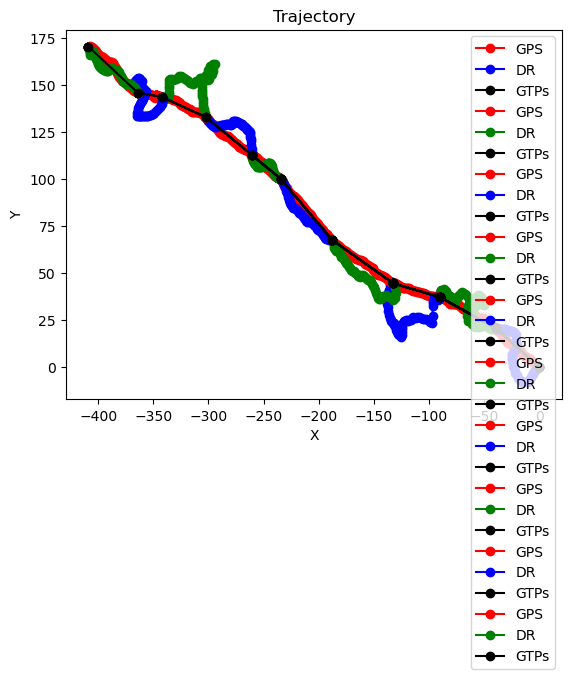

In [26]:
# Apply correction to each group
df_step = df.copy()

# Initialize empty data frame
df_corrected = pd.DataFrame(columns=df.columns)

# Get initial utm coords
utm_x0 = df.loc[start,"UTM_E"]
utm_y0 = df.loc[start,"UTM_N"]

# Create a plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Apply corrections between each set of ground truth points
for i in range(0,len(gtps)-1):
    
    # Get ground truth points
    gtp0 = gtps.iloc[i]
    gtp1 = gtps.iloc[i+1]

    # Get timestamps of GTPs
    gtp0_ts = gtp0['datetime']
    gtp1_ts = gtp1['datetime']

    # Filter for DR pts that fall between gtp1 and gtp2
    df_filt = df_step[(df_step['datetime'] >= gtp0_ts) & (df_step['datetime'] <= gtp1_ts)]
    rowIDs = df_filt['rowID'].to_list()
    s = rowIDs[0]
    e = rowIDs[-1] 

    # Get GPS coords (centered at 0,0)
    gps_x0 = gtp0['UTM_E'] - utm_x0
    gps_y0 = gtp0['UTM_N'] - utm_y0
    gps_x1 = gtp1['UTM_E'] - utm_x0
    gps_y1 = gtp1['UTM_N'] - utm_y0

    # Get dead reckoned coords
    dr_x0 = df_filt.loc[df_filt['rowID'] == s,'DR_x'].values
    dr_y0 = df_filt.loc[df_filt['rowID'] == s,'DR_y'].values
    dr_x1 = df_filt.loc[df_filt['rowID'] == e,'DR_x'].values
    dr_y1 = df_filt.loc[df_filt['rowID'] == e,'DR_y'].values


    # Define center of rotation
    x_center = dr_x0
    y_center = dr_y0
    center_of_rotation = np.array([x_center,y_center,[0]])
    
    # Subtract center of rotation from pts
    gps_x0 = 0
    gps_y0 = 0
    gps_x1 = gps_x1 - x_center
    gps_y1 = gps_y1 - y_center
    dr_x0  = 0
    dr_y0 = 0
    dr_x1 = dr_x1 - x_center
    dr_y1 = dr_y1 - y_center
    print("gps0:"+str(gps_x0) + str(gps_y0))
    print("dr0:"+str(dr_x0) + str(dr_y0))
    print("gps1:"+str(gps_x1) + str(gps_y1))
    print("dr1:"+str(dr_x1) + str(dr_y1))
    

    
    # Calculate the distance correction factor
    dist_GPS = math.sqrt((gps_x1-gps_x0)**2 + (gps_y1 - gps_y0)**2)
    dist_dr = math.sqrt((dr_x1-dr_x0)**2 + (dr_y1 - dr_y0)**2)
    dist_corr_fact = (dist_GPS/dist_dr)
    

    # Calculate heading correction factor
    bearing_GPS = math.atan2(gps_y1-gps_y0,gps_x1-gps_x0) 
    bearing_dr = math.atan2(dr_y1-dr_y0,dr_x1-dr_x0) 
    heading_corr_fact = (bearing_GPS-bearing_dr)
    if heading_corr_fact < -math.pi:
        heading_corr_fact += (360 * 0.0174533)
    elif heading_corr_fact > math.pi:
        heading_corr_fact -= (360 * 0.0174533)
    heading_correction = R.from_euler('xyz', [0,0,heading_corr_fact]).as_matrix()
    

    # Get points that will be corrected
    Xs = df_step['DR_x'].to_numpy()
    Ys = df_step['DR_y'].to_numpy()
    Zs = np.zeros(len(df_step))
    initial_coords = np.array([Xs,Ys,Zs]) - center_of_rotation
  
    rotated_coords = ((heading_correction @ initial_coords)*np.array([[dist_corr_fact],[dist_corr_fact],[dist_corr_fact]]) ) + center_of_rotation
    #translated_coords = rotated_coords * np.array([[dist_corr_fact],[dist_corr_fact],[dist_corr_fact]]) 
    new_coords = rotated_coords
    df_step['DR_x'] = new_coords[0]
    df_step['DR_y'] = new_coords[1]
    df_step['DR_z'] = new_coords[2]
    df_step['DR_utm_x'] = df_step['DR_x'] + utm_x0
    df_step['DR_utm_y'] = df_step['DR_y'] + utm_y0
    # snap end point to gps
    df_step.loc[e,'DR_utm_x'] == df_step.loc[e,'UTM_E']
    df_step.loc[e,'DR_utm_y'] == df_step.loc[e,'UTM_N']
    
    # Filter for rows between GTPs and append to df_corrected
    df_step_filt = df_step[(df_step['rowID'] >= s) & (df_step['rowID'] <= e)]
    df_corrected = pd.concat([df_corrected, df_step_filt], ignore_index=True)

    # Add results to plot
    dr_x = df_step_filt['DR_x']
    dr_y = df_step_filt['DR_y']
    utm_x = df_step_filt['UTM_E'] - utm_x0
    utm_y = df_step_filt['UTM_N'] - utm_y0
    gtps_x = gtps['UTM_E'] - utm_x0
    gtps_y = gtps['UTM_N'] - utm_y0
    if(i % 2 == 0):
        clr = "b"
    else:
        clr = "g"
    ax.plot(utm_x,utm_y, marker='o', linestyle='-', color='r', label='GPS')
    ax.plot(dr_x,dr_y, marker='o', linestyle='-', color=clr, label='DR')
    ax.plot(gtps_x,gtps_y, marker='o',  color='black', label='GTPs')


# Setting labels
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Adding a title and legend
ax.set_title('Trajectory')
ax.legend()

# Show plot
plt.show()
    

In [23]:
df_corrected[['DR_utm_x','UTM_E', 'DR_utm_y','UTM_N', 'datetime','DR_x','DR_y']]

,DR_utm_x,UTM_E,DR_utm_y,UTM_N,datetime,DR_x,DR_y
0,479777.899109,479777.899109,7.105727e+06,7.105727e+06,2019-02-25 22:25:00,0.000000,0.000000
1,479776.668505,479776.899236,7.105727e+06,7.105728e+06,2019-02-25 22:25:01,-1.230604,-0.401055
2,479775.603351,479775.899018,7.105727e+06,7.105728e+06,2019-02-25 22:25:02,-2.295758,-0.682646
3,479774.629210,479774.998909,7.105726e+06,7.105729e+06,2019-02-25 22:25:03,-3.269899,-1.057586
4,479773.963543,479773.998863,7.105726e+06,7.105729e+06,2019-02-25 22:25:04,-3.935566,-1.696488
...,...,...,...,...,...,...,...
605,479371.906797,479371.589570,7.105893e+06,7.105898e+06,2019-02-25 22:34:56,-405.992311,165.876484
606,479370.903406,479370.889836,7.105893e+06,7.105898e+06,2019-02-25 22:34:57,-406.995703,165.955288
607,479370.277526,479370.090517,7.105894e+06,7.105898e+06,2019-02-25 22:34:58,-407.621583,166.936257
608,479369.563296,479369.390959,7.105896e+06,7.105898e+06,2019-02-25 22:34:59,-408.335813,168.548988


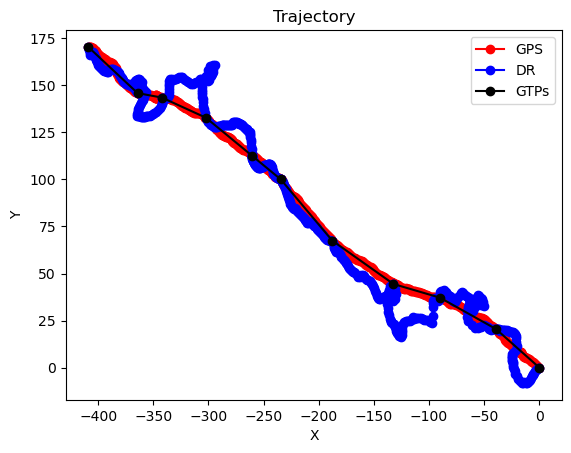

In [24]:
# Plot dead reckoned vs GPS trajectory
dr_x = df_corrected['DR_x']
dr_y = df_corrected['DR_y']
utm_x = df_corrected['UTM_E'] - utm_x0
utm_y = df_corrected['UTM_N'] - utm_y0
gtps_x = gtps['UTM_E'] - utm_x0
gtps_y = gtps['UTM_N'] - utm_y0

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory

ax.plot(utm_x,utm_y, marker='o', linestyle='-', color='r', label='GPS')
ax.plot(dr_x,dr_y, marker='o', linestyle='-', color='b', label='DR')
ax.plot(gtps_x,gtps_y, marker='o',  color='black', label='GTPs')

# Setting labels
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Adding a title and legend
ax.set_title('Trajectory')
ax.legend()

# Show plot
plt.show()

# Calculate distance correction factor
# (Euclidean distance GPS pts/ Euclidean distance DR pts)

gps_x0 = df.loc[start,'UTM_E']
gps_y0 = df.loc[start,'UTM_N']
gps_x1 = df.loc[end-1,'UTM_E']
gps_y1 = df.loc[end-1,'UTM_N']
dist_GPS = math.sqrt((gps_x1-gps_x0)**2 + (gps_y1 - gps_y0)**2)

dr_x0 = df.loc[start,'DR_utm_x']
dr_y0 = df.loc[start,'DR_utm_y']
dr_x1 = df.loc[end-1,'DR_utm_x']
dr_y1 = df.loc[end-1,'DR_utm_y']
dist_dr = math.sqrt((dr_x1-dr_x0)**2 + (dr_y1 - dr_y0)**2)

dist_corr_fact = dist_GPS/dist_dr
print(dist_corr_fact)

# Calculate heading correction factor

bearing_GPS = math.atan2(gps_y1-gps_y0,gps_x1-gps_x0) 
print(bearing_GPS)
bearing_dr = math.atan2(dr_y1-dr_y0,dr_x1-dr_x0) 
print(bearing_dr)

heading_corr_fact = (bearing_GPS-bearing_dr)
print(heading_corr_fact)

if heading_corr_fact < -math.pi:
    heading_corr_fact += 360 * 0.0174533
elif heading_corr_fact > math.pi:
    heading_corr_fact -= 360 * 0.0174533

# Update speed and distance values using the distance correction factor

df['d'] = df['d'] * dist_corr_fact


# re-initialize position
position = np.array([[0],[0],[0]])

# Apply speed correction

for i in range(len(df)-1 ):

    i += start

    # Re-construct the rotation matrix
    pitch = df.loc[i,'pitch']
    roll = df.loc[i,'roll']
    yaw = df.loc[i,'yaw']
    Rx = get_rx(pitch)
    Ry = get_ry(roll)
    Rz = get_rz(yaw)
    heading_correction = R.from_euler('xyz', [0,0,heading_corr_fact]).as_matrix()
    rotation_matrix =  heading_correction@Rz @ Ry @ Rx

    # Re-compute the displacement vector
    direction_vector = rotation_matrix @ initial_direction
    distance = df.loc[i,'d']
    displacement_vector = direction_vector * distance
        
    #update homo_trans_step
    transformation_step = np.append(np.append(rotation_matrix, np.zeros([3,1]), axis = 1), np.array([[0,0,0,1]]), axis = 0)
    transformation_step[:3,-1] = displacement_vector.flatten()

    #update overall transform
    transformation_matrix = transformation_matrix @ transformation_step

    # Perform final calculation of coordinates
    current_position = position
    next_position = current_position + displacement_vector
    df.loc[i+1,'DR_x'] = next_position[0]
    df.loc[i+1,'DR_utm_x'] = displacement_vector[0] + df.loc[i,'DR_utm_x']
    df.loc[i+1,'DR_y'] = next_position[1]
    df.loc[i+1,'DR_utm_y'] = displacement_vector[1] + df.loc[i,'DR_utm_y']
    df.loc[i+1,'DR_z'] = next_position[2]

    position = next_position

# Apply heading correction
# Xs = df['DR_x'].to_numpy()
# Ys = df['DR_y'].to_numpy()
# Zs = np.zeros(len(df))
# initial_coords = np.array([Xs,Ys,Zs])
# heading_correction = R.from_euler('xyz', [0,0,heading_corr_fact]).as_matrix()
# new_coords = heading_correction @ initial_coords
# df['DR_x'] = new_coords[0]
# df['DR_y'] = new_coords[1]
# df['DR_z'] = new_coords[2]
# df['DR_utm_x'] = df['DR_x'] + df.loc[start,'UTM_E']
# df['DR_utm_y'] = df['DR_y'] + df.loc[start,'UTM_N']






In [25]:
df_filt.head(10)

,Acc_x,Acc_y,Acc_z,Mag_x,Mag_y,Mag_z,datetime,elapsed_time,Date,Time,...,m,c,s,d,rowID,DR_x,DR_y,DR_z,DR_utm_x,DR_utm_y
591,-0.073120,-0.253101,-1.023486,0.023267,0.030957,-0.272217,2019-02-25 22:34:00,1.0,25/02/2019,22:34:00,...,1,0.1,0.142022,0.142022,591,-364.297167,145.835238,0.0,479413.601942,7.105873e+06
592,-0.117505,-0.239868,-0.961084,0.015625,0.020825,-0.273731,2019-02-25 22:34:01,1.0,25/02/2019,22:34:01,...,1,0.1,0.171530,0.171530,592,-364.844820,144.935347,0.0,479413.054289,7.105872e+06
593,-0.151074,-0.243482,-1.012696,0.018555,0.020776,-0.272973,2019-02-25 22:34:02,1.0,25/02/2019,22:34:02,...,1,0.1,0.197353,0.197353,593,-365.198706,143.713752,0.0,479412.700402,7.105871e+06
594,-0.117505,-0.227905,-0.970705,0.023340,0.012720,-0.271655,2019-02-25 22:34:03,1.0,25/02/2019,22:34:03,...,1,0.1,0.150434,0.150434,594,-365.662021,142.326149,0.0,479412.237088,7.105870e+06
595,-0.146289,-0.273535,-1.009107,0.024609,0.007153,-0.271314,2019-02-25 22:34:04,1.0,25/02/2019,22:34:04,...,1,0.1,0.170509,0.170509,595,-366.011732,141.268415,0.0,479411.887377,7.105869e+06
596,-0.127051,-0.281909,-0.950269,0.012158,0.017920,-0.272778,2019-02-25 22:34:05,1.0,25/02/2019,22:34:05,...,1,0.1,0.158211,0.158211,596,-366.345397,140.051819,0.0,479411.553712,7.105867e+06
597,-0.158276,-0.268677,-0.974269,0.013477,0.025732,-0.273316,2019-02-25 22:34:06,1.0,25/02/2019,22:34:06,...,1,0.1,0.154842,0.154842,597,-366.212928,138.889843,0.0,479411.686181,7.105866e+06
598,-0.119873,-0.267529,-0.982666,0.029639,0.016699,-0.270044,2019-02-25 22:34:07,1.0,25/02/2019,22:34:07,...,1,0.1,0.117947,0.117947,598,-366.074873,137.755032,0.0,479411.824236,7.105865e+06
599,-0.135498,-0.218311,-0.986256,0.014673,0.029492,-0.272925,2019-02-25 22:34:08,1.0,25/02/2019,22:34:08,...,1,0.1,0.133447,0.133447,599,-366.267741,136.906332,0.0,479411.631368,7.105864e+06
600,-0.136719,-0.283081,-1.022290,0.002783,0.023853,-0.275049,2019-02-25 22:34:09,1.0,25/02/2019,22:34:09,...,1,0.1,0.143681,0.143681,600,-366.139408,135.930981,0.0,479411.759701,7.105863e+06


# APPLY DISTANCE AND HEADING CORRECTIONS

# Calculate distance correction factor
# (Euclidean distance GPS pts/ Euclidean distance DR pts)

gps_x0 = df.loc[start,'UTM_E']
gps_y0 = df.loc[start, 'UTM_N']
gps_x1 = df.loc[end-1,'UTM_E']
gps_y1 = df.loc[end-1,'UTM_N']
dist_GPS = math.sqrt((gps_x1-gps_x0)**2 + (gps_y1 - gps_y0)**2)

dr_x0 = df.loc[start,'DR_utm_x']
dr_y0 = df.loc[start, 'DR_utm_y']
dr_x1 = df.loc[end-1,'DR_utm_x']
dr_y1 = df.loc[end-1,'DR_utm_y']
dist_dr = math.sqrt((dr_x1-dr_x0)**2 + (dr_y1 - dr_y0)**2)

dist_corr_fact = dist_GPS/dist_dr

# Update distance values using the distance correction factor

df['d'] = df['d'] * dist_corr_fact

# Calculate heading correction factor

bearing_GPS = math.atan2(gps_y1,gps_x1) - math.atan2(gps_y0,gps_x0)

bearing_dr = math.atan2(dr_y1,dr_x1) - math.atan2(dr_y0,dr_x0)

heading_corr_fact = bearing_GPS - bearing_dr

if heading_corr_fact < -180:
    heading_corr_fact += (360 * 0.0174533)
elif heading_corr_fact > 180:
    heading_corr_fact -= (360 * 0.0174533)
    
# Update heading using heading correction factor
df['yaw'] += heading_corr_fact 

# Initialize position
position = np.array([[0],[0],[0]])

# Initialze distance between DR and GPS pts column
df['dist_dr_GPS'] = -999.0
df.loc[start,'dist_dr_GPS'] = 0

for i in range(len(df)-1 ):

    i += start

    # Re-construct the rotation matrix
    pitch = df.loc[i,'pitch']
    roll = df.loc[i,'roll']
    yaw = df.loc[i,'yaw']
    Rx = get_rx(pitch)
    Ry = get_ry(roll)
    Rz = get_rz(yaw)
    rotation_matrix = Rz @ Ry @ Rx

    # Re-compute the displacement vector
    direction_vector = rotation_matrix @ initial_direction
    distance = df.loc[i,'d']
    displacement_vector = direction_vector * distance
        
    #update homo_trans_step
    transformation_step = np.append(np.append(rotation_matrix, np.zeros([3,1]), axis = 1), np.array([[0,0,0,1]]), axis = 0)
    transformation_step[:3,-1] = displacement_vector.flatten()

    #update overall transform
    transformation_matrix = transformation_matrix @ transformation_step

    # Perform final calculation of coordinates
    current_position = position
    next_position = current_position + displacement_vector
    df.loc[i+1,'DR_x'] = next_position[0]
    df.loc[i+1,'DR_utm_x'] = displacement_vector[0] + df.loc[i,'DR_utm_x']
    df.loc[i+1,'DR_y'] = next_position[1]
    df.loc[i+1,'DR_utm_y'] = displacement_vector[1] + df.loc[i,'DR_utm_y']
    df.loc[i+1,'DR_z'] = next_position[2]

    # Compute distance between DR and GPS pts
    dr_x = df.loc[i+1,'DR_utm_x']
    dr_y = df.loc[i+1,'DR_utm_y']
    gps_x = df.loc[i+1,'UTM_E']
    gps_y = df.loc[i+1,'UTM_N']
    dist_dr_gps = math.sqrt((dr_x-gps_x)**2 + (dr_y - gps_y)**2)
    
    position = next_position



# Plot dead reckoned vs GPS trajectory

dr_x = df['DR_x']
dr_y = df['DR_y']
utm_x = df['UTM_E'] - df.loc[start,'UTM_E']
utm_y = df['UTM_N'] - df.loc[start,'UTM_N']

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(dr_x,dr_y, marker='o', linestyle='-', color='b', label='DR')
ax.plot(utm_x,utm_y, marker='o', linestyle='-', color='r', label='GPS')

# Setting labels
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Adding a title and legend
ax.set_title('Trajectory')
ax.legend()

# Show plot
plt.show()

## VISUALIZE RESULTS

def draw_frame(fig, homo_trans, alpha = 1.):
    """fig = plotly figure object
       homo_trans = homogenous transformation matrix (4x4)"""

    x0 = homo_trans[0,3]
    y0 = homo_trans[1,3]
    z0 = homo_trans[2,3]
    x1, y1, z1 =  np.eye(3) @ homo_trans[:3,:3]
    x1 += homo_trans[0,-1]
    y1 += homo_trans[1,-1]
    z1 += homo_trans[2,-1]
    fig.add_trace(go.Scatter3d(x=[x0, x1[0]], y=[y0, y1[0]], z=[z0, z1[0]], mode='lines', line=dict(color='rgba(255, 0, 0, ' +str(alpha) + ')', width=5)))
    fig.add_trace(go.Scatter3d(x=[x0, x1[1]], y=[y0, y1[1]], z=[z0, z1[1]], mode='lines', line=dict(color='rgba(0, 255, 0, ' +str(alpha) + ')', width=5)))
    fig.add_trace(go.Scatter3d(x=[x0, x1[2]], y=[y0, y1[2]], z=[z0, z1[2]], mode='lines', line=dict(color='rgba(0, 0, 255, ' +str(alpha) + ')', width=5)))

# Create a 3D figure
fig = go.Figure()
fig.update_layout(
    scene=dict(
        aspectmode='data'  # ensures all axes are scaled equally
    )
)

#initialize 3x3 rotation matrix
#euler_angles = [0.,0.,0.] #rotation about xaxis, yaxis, zaxis
# print("\n rotation matrix (3x3) \n", rotm, "\n")

#initialize translation vector
trans_vec = np.array([[0., 0., 0]]) #[x, y, z]
# print("\n translation vector (3x1) \n", trans_vec)

#resize rotation matrix to 4x4 so it can be used with homogenous cooridnates
#update homo_trans to include translation as well
#print("\n homogenous transformation matrix (4x4) for pose 0 \n", homo_trans ,"\n")


runLen = len(df)

draw_frame(fig, np.eye(4), alpha = 1/runLen)
homo_trans = np.eye(4)

for i in range(runLen):
    if i%50 == 0:
        plot = True
    else:
        plot = False
    i = i + 9
    row = df[df['rowID']==i]

    #update translation
    row_label = row.index[0]
    heading = row.at[row_label,'H']
    speed = row.at[row_label,'s']
    new_trans_step = get_translation_vector(heading = heading, speed = speed)
    
    #update rotation
    pitch = row['pitch']
    Rx = get_rx(pitch = pitch)
    
    roll = row['roll']
    Ry = get_ry(roll = roll)

    yaw = roll['H']
    Rz = get_rz(
    
    new_rotm_step = Rx @ Ry
    
    #update homo_trans_step
    homo_trans_step = np.append(np.append(new_rotm_step, np.zeros([3,1]), axis = 1), np.array([[0,0,0,1]]), axis = 0)
    homo_trans_step[:3,-1] = new_trans_step
    
    
    #update overall transform
    homo_trans = homo_trans @ homo_trans_step
    
#     print("\n overall homogenous transformation matrix (4x4) for pose", i + 1, "\n", homo_trans ,"\n")
#     print("\n just since the last frame \n", homo_trans_step, "\n")
    
    #add to figure
    if plot == True:
        draw_frame(fig, homo_trans, (i+1)/(runLen+1))


fig.show()

df.colnames()